### Libraries & Packages

In [ ]:
# data processessing packages
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## NN packages
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from sklearn.metrics import classification_report

# NLP packages
!pip install -q transformers
!pip install pydot
from transformers import BertTokenizer,TFAutoModel, TFBertModel, BertForSequenceClassification,TFAutoModelForSequenceClassification




### Importing/Preprocessing data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_data = pd.read_csv('/content/clean_train_data.csv')
test_data = pd.read_csv('/content/clean_test_data.csv')

In [ ]:
train_data

,Unnamed: 0,text,label
0,0,Here are Thursday's biggest analyst calls: App...,0
1,1,Buy Las Vegas Sands as travel to Singapore bui...,0
2,2,"Piper Sandler downgrades DocuSign to sell, cit...",0
3,3,"Analysts react to Tesla's latest earnings, bre...",0
4,4,Netflix and its peers are set for a ‘return to...,0
...,...,...,...
16985,16985,KfW credit line for Uniper could be raised to ...,3
16986,16986,KfW credit line for Uniper could be raised to ...,3
16987,16987,Russian sells 1 bln roubles at one-year repo...,3
16988,16988,Global ESG bond issuance posts H1 dip as supra...,3


In [ ]:
# creating train/val datasets
x_train, x_val, y_train, y_val = train_test_split(train_data.text, train_data.label, test_size=0.20, random_state=42)
# creating test datasets
x_test = test_data.text
y_test = test_data.label

In [ ]:
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}\n")
print(f"x_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}\n")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")


x_train shape: (13592,)
y_train shape: (13592,)

x_val shape: (3398,)
y_val shape: (3398,)

x_test shape: (4117,)
y_test shape: (4117,)


### Gloabl Variables

In [ ]:
# Creating of learning rate schedule
num_epochs = 5
num_train_steps = len(x_train) * num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5,
    end_learning_rate=0.,
    decay_steps=num_train_steps
)

In [ ]:
target_names = ["Analyst Update","Fed | Central Banks",
        "Company | Product News","Treasuries | Corporate Debt",
        "Dividend","Earnings","Energy | Oil",
        "Financials","Currencies","General News | Opinion",
        "Gold | Metals | Materials","IPO","Legal | Regulation",
        "M&A | Investments","Macro","Markets","Politics",
        "Personnel Change","Stock Commentary", "Stock Movement"]

### Utility functions

In [ ]:
# Function for creating tokenized data and outputs for models

def create_datasets(tokenizer, train=x_train, val=x_val, test=x_test):
  # Variables
  # train/val/test = datasets to encode
  # tokenizer = bert tokenizer

  train_encodings = tokenizer(list(train), padding=True, return_tensors='tf')
  valid_encodings = tokenizer(list(val), padding=True, return_tensors='tf')
  test_encodings = tokenizer(list(test), padding=True, return_tensors='tf')

  return train_encodings, valid_encodings, test_encodings


In [ ]:
 # Function for creating model
def create_bert_multiclass_model(model,
                                 num_classes = 20,
                                 hidden_size = 201,
                                 dropout=0.3,
                                 learning_rate=lr_scheduler,
                                 activation='softmax'):
    """
    Build a simple classification model with BERT. Use the Pooler Output for classification purposes.
    """

    bert_model = model

    # building bert inputs
    input_ids = tf.keras.layers.Input(shape=(None,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(None,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(None,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    # building bert model
    bert_out = bert_model(bert_inputs)
    pooler_output = bert_out[1] # bert_out.pooler_output

    # building hidden layers
    last_hidden_output = tf.keras.layers.Dense(hidden_size, activation='relu', name='last_hidden_output')(pooler_output)
    last_hidden_output = tf.keras.layers.Dropout(dropout, name='dropout')(last_hidden_output)
    bert_cls_prediction = keras.layers.Dense(num_classes, activation=activation, name='cls_output')(last_hidden_output)

    # compiling model
    bert_cls_model = keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=bert_cls_prediction)
    bert_cls_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                           loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                           metrics='accuracy')

    ### END YOUR CODE
    return bert_cls_model

In [ ]:
# Function to show model parameters/shape
def depict_model(model):

  display(model.summary())
  display(keras.utils.plot_model(model, show_shapes=False, show_dtype=False, show_layer_names=True, dpi=90))

In [ ]:
#Function to create confusion matrix
def plot_confusion_matrix(conf_matrix, target_names, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(title)
    plt.show()

In [ ]:
## FUNCTION FOR GENERATING WRONG ANSWER DATA SET
def wrong_answer_eval(y_pred, y_target, test_data=test_data):

  y_pred = y_pred.numpy()
  wrong_answ = test_data[(y_pred != y_target)]
  wrong_answ['predicted_label'] = y_pred[np.where([y_target != y_pred])[1]]

  return wrong_answ


## FUNCTION FOR SAMPLING DATA

def preview_random_sample(df, labels=target_names, sample_num = 10):
    # A function to grab a random sample and display the text and associated labels

    # VARIABLES
    # df = dataframe
    # col_name = name of column to display
    # sample_num = number of samples to display

    # generating random sample
    random_sample = df.sample(sample_num)

    # looping over sampple an displaying results
    for i, data in enumerate(random_sample.iterrows()):
        print(f'RECORD {i+1}')
        print(f'Text: {data[1].text}')
        print(f'True Label: {labels[data[1].label]}')
        print(f'Predicted Label: {labels[data[1].predicted_label]}\n')

    return 'SAMPLING COMPLETE'

In [ ]:
## FUNCTION TO SEE HOW ACCURATE MODEL PREDICT TOP K LABELS
def top_k_pred_acc(top_k_preds, y_test=y_test):

  # tracking variables
  correct_preds = 0
  total_preds = 0

  for i,label in enumerate(y_test):
    if label in top_k_preds[i-1]:
      correct_preds += 1
    total_preds +=1

  acc = correct_preds/total_preds

  return f"Accuracy: {acc:.4f}"

### BERT-base model

In [ ]:
# Loading bert-base-uncased tokenizer/model
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
# Creating base-base-uncased encodings
base_train_encodings, base_valid_encodings, base_test_encodings = create_datasets(bert_tokenizer)

In [ ]:
# Creating bert-base-uncased model
bert_base_Fit = create_bert_multiclass_model(bert_model)

In [ ]:
# Running BERT-base-Fit model
bertbase_model_history = bert_base_Fit.fit([base_train_encodings.input_ids, base_train_encodings.token_type_ids, base_train_encodings.attention_mask],
                                                  y_train,
                                                  validation_data=([base_valid_encodings.input_ids, base_valid_encodings.token_type_ids, base_valid_encodings.attention_mask],
                                                  y_val),
                                                  batch_size=8,
                                                  epochs=num_epochs)

Epoch 1/5
1699/1699 [==============================] - 235s 112ms/step - loss: 0.9316 - accuracy: 0.7423 - val_loss: 0.4871 - val_accuracy: 0.8632
Epoch 2/5
1699/1699 [==============================] - 164s 97ms/step - loss: 0.3832 - accuracy: 0.8936 - val_loss: 0.4185 - val_accuracy: 0.8905
Epoch 3/5
1699/1699 [==============================] - 163s 96ms/step - loss: 0.2363 - accuracy: 0.9333 - val_loss: 0.4579 - val_accuracy: 0.8905
Epoch 4/5
1699/1699 [==============================] - 167s 98ms/step - loss: 0.1593 - accuracy: 0.9565 - val_loss: 0.4827 - val_accuracy: 0.8888
Epoch 5/5
1699/1699 [==============================] - 166s 98ms/step - loss: 0.1292 - accuracy: 0.9656 - val_loss: 0.5458 - val_accuracy: 0.8961


In [ ]:
bert_base_fit_results = bert_base_Fit.evaluate([base_test_encodings.input_ids, base_test_encodings.token_type_ids, base_test_encodings.attention_mask],
                                         y_test,
                                         batch_size=8)

print(f"Model accuracy: {bert_base_fit_results[1]}\n"+
      f"Model loss: {bert_base_fit_results[0]}")

515/515 [==============================] - 29s 52ms/step - loss: 0.5370 - accuracy: 0.8880
Model accuracy: 0.8880252838134766
Model loss: 0.5369675755500793


In [ ]:
# Computing BERT-base-Fit F1 metric
bert_fit_y_pred = bert_base_Fit.predict([base_test_encodings.input_ids, base_test_encodings.token_type_ids, base_test_encodings.attention_mask])
pred_bert_fit_model = tf.argmax(bert_fit_y_pred, axis=-1)

print(classification_report(y_test, pred_bert_fit_model.numpy(), target_names=target_names, digits=4))



129/129 [==============================] - 19s 117ms/step
                             precision    recall  f1-score   support

             Analyst Update     0.8358    0.7671    0.8000        73
        Fed | Central Banks     0.8603    0.9206    0.8894       214
     Company | Product News     0.9241    0.9002    0.9120       852
Treasuries | Corporate Debt     0.9385    0.7922    0.8592        77
                   Dividend     0.9600    0.9897    0.9746        97
                   Earnings     0.9620    0.9421    0.9520       242
               Energy | Oil     0.9732    0.7466    0.8450       146
                 Financials     0.8547    0.9563    0.9027       160
                 Currencies     0.8857    0.9688    0.9254        32
     General News | Opinion     0.7694    0.8542    0.8096       336
  Gold | Metals | Materials     0.8000    0.9231    0.8571        13
                        IPO     0.8667    0.9286    0.8966        14
         Legal | Regulation     0.8850    0.

In [ ]:
# Saving model & weights
bert_base_Fit.save_weights('/content/drive/MyDrive/Colab Notebooks/checkpoint/BERT-base-Fit-weights.h5')
bert_base_Fit.save('/content/drive/MyDrive/Colab Notebooks/checkpoint/BERT-base-Fit-model.keras')
bert_model.save_weights('/content/drive/MyDrive/Colab Notebooks/checkpoint/Bert-base-fit-modelWeights.h5')

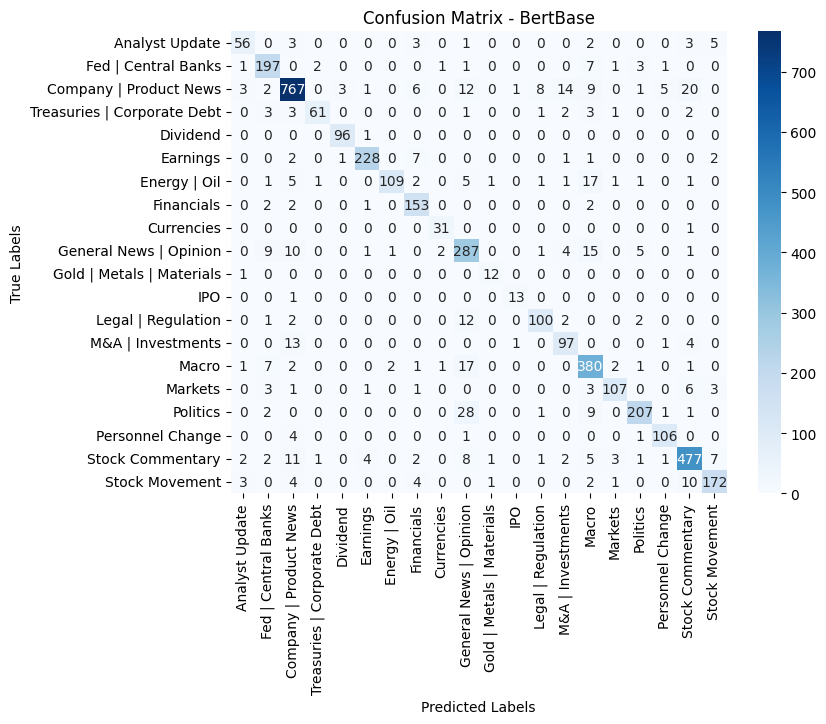

In [ ]:
#bertbase Conf matrix
bert_conf_matrix = confusion_matrix(y_test, pred_bert_fit_model.numpy())
plot_confusion_matrix(bert_conf_matrix, target_names, "Confusion Matrix - BertBase")

In [ ]:
#Looking at wrong answers
wa = wrong_answer_eval(pred_bert_fit_model, y_test)
preview_random_sample(wa)

RECORD 1
Text: Indonesia will push the Group of 20 as this year’s host to include the African Union to ensure the plight and concerns of the continent would be represented in key meetings  
True Label: Politics
Predicted Label: Macro

RECORD 2
Text: Options expect earnings-day moves to average +/- 6.1% this quarter, the third highest in the past 12 years  
True Label: Earnings
Predicted Label: Macro

RECORD 3
Text: 🇪🇺🇭🇷 Croatia will adopt the euro as of next year!   The country fulfils all convergence criteria, the Council of the European Union agreed today. Croatia is now formally approved to join the euro area on 1 January 2023.  Press release    
True Label: Macro
Predicted Label: Currencies

RECORD 4
Text: $PETZ Request for Withdrawal of Registration Statement on Form F-3 .... can get wild in afterhours
True Label: Company | Product News
Predicted Label: Stock Commentary

RECORD 5
Text: $BYDDF $BYDDY - Rumors Of Warren Buffett Selling Stake In BYD Create Opportunity.   #markets #in

<ipython-input-12-f209e72932a5>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wrong_answ['predicted_label'] = y_pred[np.where([y_target != y_pred])[1]]


'SAMPLING COMPLETE'

In [ ]:
preview_random_sample(wa)

RECORD 1
Text: “We had a tough six weeks and we own that at Delta,” says Delta CEO Ed Bastian. He joined @lebeaucarnews to discuss the company’s Q2 earnings and third quarter outlook.    
True Label: Company | Product News
Predicted Label: Earnings

RECORD 2
Text: $DCO - Ducommun: Aerospace Industry's Today Best Near-Term Capital Gain.   #stocks #economy #investing
True Label: Stock Commentary
Predicted Label: Stock Movement

RECORD 3
Text: Crypto lender Genesis gave $2.36 billion to Three Arrows Capital
True Label: Company | Product News
Predicted Label: M&A | Investments

RECORD 4
Text: $PM - Philip Morris International pushes higher after earnings topper  
True Label: Stock Movement
Predicted Label: Financials

RECORD 5
Text: $ALLY - Ally Financial Offers A Sustainable 16-18% ROTCE And Trades Around Tangible Book.   #markets #trading #economy
True Label: Company | Product News
Predicted Label: Stock Commentary

RECORD 6
Text: Soybeans weak today but appears a buyer in March 2023 fut

'SAMPLING COMPLETE'

In [ ]:
#Review of the top predictions
top_3 = tf.math.top_k(bert_fit_y_pred,k=3).indices
top_2 = tf.math.top_k(bert_fit_y_pred,k=2).indices

In [ ]:
print('Accuracy when checking top 3 predictions')
top_k_pred_acc(top_3)

Accuracy when checking top 3 predictions


'Accuracy: 0.9689'

In [ ]:
print('Accuracy when checking top 2 predictions')
top_k_pred_acc(top_2)

Accuracy when checking top 2 predictions


'Accuracy: 0.9517'

### Finbert-pretrained Model
Basic pretrained model

In [ ]:
# Loading finbert-pretrained
finbert_base_model = TFAutoModel.from_pretrained('yiyanghkust/finbert-pretrain', ignore_mismatched_sizes=True, from_pt=True)
finbert_base_tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-pretrain')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

In [ ]:
# Creating base-base-uncased encodings
finbert_base_train_encodings, finbert_base_valid_encodings, finbert_base_test_encodings = create_datasets(finbert_base_tokenizer)

In [ ]:
# Creating FinBert-Fit model
finbert_fit_model = create_bert_multiclass_model(finbert_base_model)

In [ ]:
# Running FinBert-Fit model
finbert_base_model_history = finbert_fit_model.fit([finbert_base_train_encodings.input_ids, finbert_base_train_encodings.token_type_ids, finbert_base_train_encodings.attention_mask],
                                                  y_train,
                                                  validation_data=([finbert_base_valid_encodings.input_ids, finbert_base_valid_encodings.token_type_ids, finbert_base_valid_encodings.attention_mask],
                                                  y_val),
                                                  batch_size=8,
                                                  epochs=num_epochs)

Epoch 1/5
1699/1699 [==============================] - 253s 117ms/step - loss: 0.7992 - accuracy: 0.7698 - val_loss: 0.4389 - val_accuracy: 0.8673
Epoch 2/5
1699/1699 [==============================] - 168s 99ms/step - loss: 0.3235 - accuracy: 0.9047 - val_loss: 0.4863 - val_accuracy: 0.8743
Epoch 3/5
1699/1699 [==============================] - 167s 98ms/step - loss: 0.2043 - accuracy: 0.9392 - val_loss: 0.5019 - val_accuracy: 0.8852
Epoch 4/5
1699/1699 [==============================] - 166s 98ms/step - loss: 0.1542 - accuracy: 0.9559 - val_loss: 0.5117 - val_accuracy: 0.8882
Epoch 5/5
1699/1699 [==============================] - 166s 98ms/step - loss: 0.1235 - accuracy: 0.9665 - val_loss: 0.5649 - val_accuracy: 0.8840


In [ ]:
# Testing model with lr
finbert_fit_results = finbert_fit_model.evaluate([finbert_base_test_encodings.input_ids, finbert_base_test_encodings.token_type_ids, finbert_base_test_encodings.attention_mask],
                                         y_test,
                                         batch_size=8)

print(f"Model accuracy: {finbert_fit_results[1]}\n"+
      f"Model loss: {finbert_fit_results[0]}")

515/515 [==============================] - 28s 49ms/step - loss: 0.5897 - accuracy: 0.8737
Model accuracy: 0.8736944198608398
Model loss: 0.5897218585014343


In [ ]:
# Computing FinBert-Fit F1 metric
finbert_fit_y_pred = finbert_fit_model.predict([finbert_base_test_encodings.input_ids, finbert_base_test_encodings.token_type_ids, finbert_base_test_encodings.attention_mask])
pred_finbert_fit_model = tf.argmax(finbert_fit_y_pred, axis=-1)

print(classification_report(y_test, pred_finbert_fit_model.numpy(), target_names=target_names, digits=4))

129/129 [==============================] - 16s 105ms/step
                             precision    recall  f1-score   support

             Analyst Update     0.8382    0.7808    0.8085        73
        Fed | Central Banks     0.9300    0.8692    0.8986       214
     Company | Product News     0.8457    0.8944    0.8694       852
Treasuries | Corporate Debt     0.9104    0.7922    0.8472        77
                   Dividend     0.9688    0.9588    0.9637        97
                   Earnings     0.9186    0.9793    0.9480       242
               Energy | Oil     0.9248    0.8425    0.8817       146
                 Financials     0.7550    0.9437    0.8389       160
                 Currencies     0.8108    0.9375    0.8696        32
     General News | Opinion     0.8080    0.7768    0.7921       336
  Gold | Metals | Materials     0.8571    0.9231    0.8889        13
                        IPO     0.9286    0.9286    0.9286        14
         Legal | Regulation     0.8750    0.

In [ ]:
# Saving FinBert-Fit model & weights
finbert_fit_model.save_weights('/content/drive/MyDrive/Colab Notebooks/checkpoint/FinBert-Fit-weights.h5')
finbert_fit_model.save('/content/drive/MyDrive/Colab Notebooks/checkpoint/FinBert-Fit-model.keras')
finbert_base_model.save_weights('/content/drive/MyDrive/Colab Notebooks/checkpoint/FinBert-fit-modelWeights.h5')

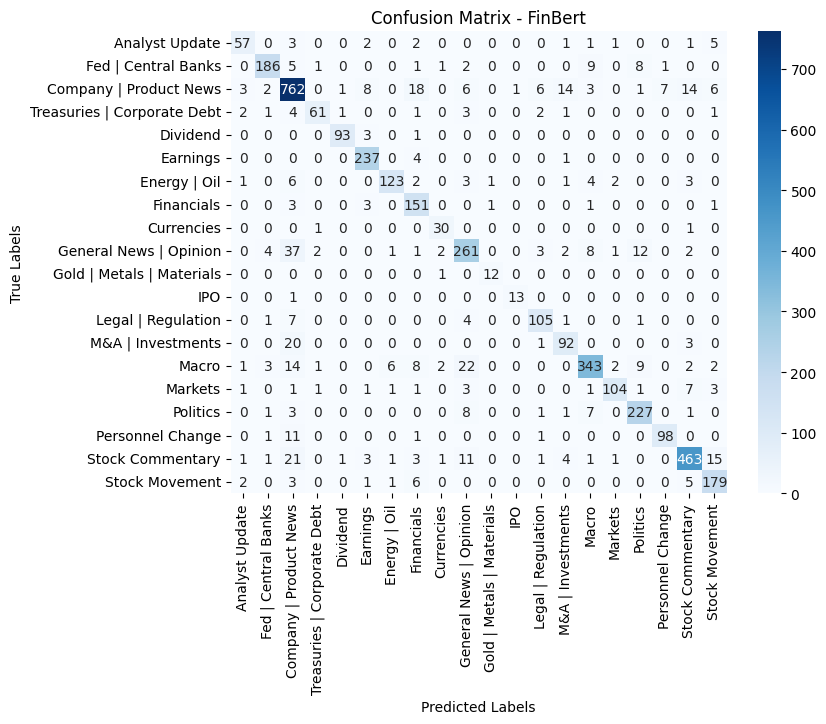

In [ ]:
#FinBert Conf matrix
finbert_conf_matrix = confusion_matrix(y_test, pred_finbert_fit_model.numpy())
plot_confusion_matrix(finbert_conf_matrix, target_names, "Confusion Matrix - FinBert")

In [ ]:
wa = wrong_answer_eval(pred_finbert_fit_model, y_test)
preview_random_sample(wa)

RECORD 1
Text: APPLE REACHES $50 MLN SETTLEMENT OVER DEFECTIVE MACBOOK KEYBOARDS - RTRS
True Label: Company | Product News
Predicted Label: Legal | Regulation

RECORD 2
Text: BitOoda Expands into Proof of Stake with Hire of Recognized PoS Expert    
True Label: Company | Product News
Predicted Label: M&A | Investments

RECORD 3
Text: Michael S. Barr sworn in as Vice Chair for Supervision of the Board of Governors of the Federal Reserve System:    
True Label: Fed | Central Banks
Predicted Label: Personnel Change

RECORD 4
Text: Non-fuel costs “came in about 22% higher than June of [2019] largely due to the fact that we are only 82% restored,” @Delta CEO Ed Bastian told Yahoo Finance. Full comments:  
True Label: Company | Product News
Predicted Label: Macro

RECORD 5
Text: @network_surrey The market started to price it in last Friday after NFP, although small odds currently. If CPI comes in over 8, and no Fed meeting in August, it could move up.
True Label: Macro
Predicted Label: Fed |

<ipython-input-12-f209e72932a5>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wrong_answ['predicted_label'] = y_pred[np.where([y_target != y_pred])[1]]


'SAMPLING COMPLETE'

In [ ]:
top_3 = tf.math.top_k(bert_fit_y_pred,k=3).indices
top_2 = tf.math.top_k(bert_fit_y_pred,k=2).indices

In [ ]:
print('Accuracy when checking top 3 predictions')
top_k_pred_acc(top_3)

Accuracy when checking top 3 predictions


'Accuracy: 0.9689'

In [ ]:
print('Accuracy when checking top 2 predictions')
top_k_pred_acc(top_2)

Accuracy when checking top 2 predictions


'Accuracy: 0.9517'

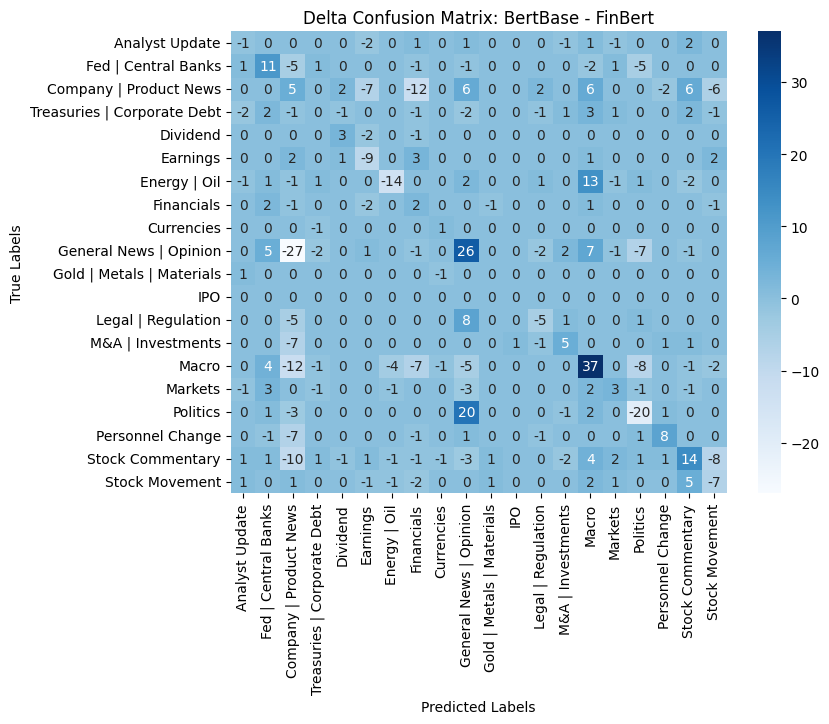

In [ ]:
delta_cm = bert_conf_matrix - finbert_conf_matrix
plot_confusion_matrix(delta_cm, target_names, "Delta Confusion Matrix: BertBase - FinBert")